[[ 4.93793077 -2.62150417]
 [-1.73728355  6.0474439 ]
 [ 1.40865625 -2.33207308]
 ...
 [-6.63775626 -5.38217455]
 [ 1.21503104  0.45673594]
 [-7.64534674 -5.12399001]]


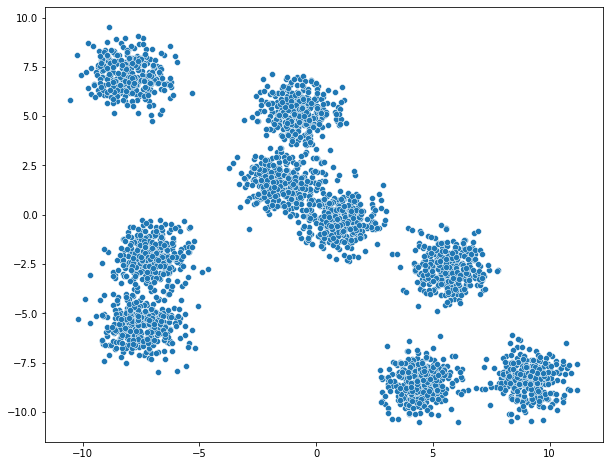

/home/vangelis/.local/share/virtualenvs/machine-learning-msc-sNBHIkKd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vangelis/.local/share/virtualenvs/machine-learning-msc-sNBHIkKd/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


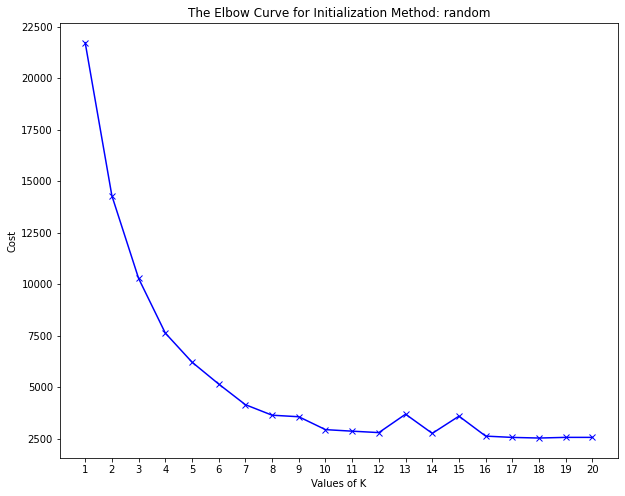

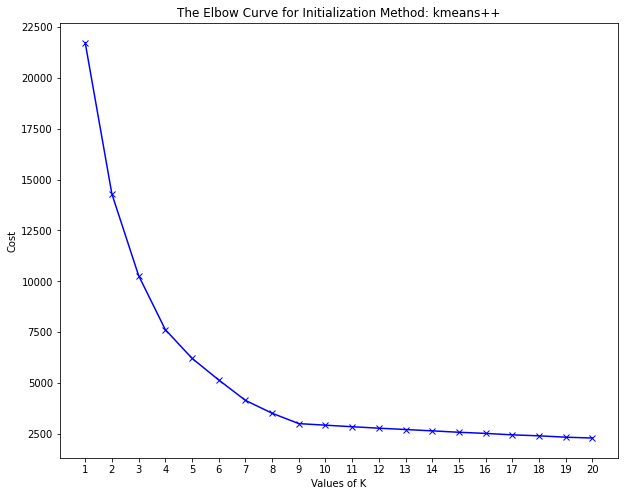

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 8)})


class KMeans:
    def __init__(self, k: int, init_method: str) -> None:
        self.k = k
        self.labels = None
        self.centroids = [None] * k
        self.cost = None
        if init_method == 'random':
            self.init = self._random_init
            self.init_str = 'random'
        elif init_method == 'kmeans++':
            self.init = self._k_means_plus_plus_init
            self.init_str = 'kmeans++'
        else:
            raise Exception("Unknown init method. Available choices are: 'random', 'kmeans++'")

    def _random_init(self, X: np.array) -> None:
        """Random initialization of KMeans
        :param X: NxD matrix where N: number of examples, D: dimensionality of data
        :return: None
        """
        self.labels = np.random.randint(low=1, high=self.k + 1, size=X.shape[0])

    def _k_means_plus_plus_init(self, X: np.array) -> None:
        """ KMeans++ initialization of KMeans
        :param X: NxD matrix where N: number of examples, D: dimensionality of data
        :return: None
        """
        centroids = list()
        centroids.append(X[np.random.randint(X.shape[0]), :])

        for cluster_id in range(self.k - 1):
            # Initialize a list to store distances of data points from nearest centroid
            dist = []
            for i in range(X.shape[0]):
                point = X[i, :]
                d = sys.maxsize

                # Compute the minimum distance of 'point' from each of the previously selected centroid
                for j in range(len(centroids)):
                    temp_dist = np.sum((point - centroids[j]) ** 2)
                    d = min(d, temp_dist)
                dist.append(d)

            # Select data point with maximum distance as our next centroid
            dist = np.array(dist)
            next_centroid = X[np.argmax(dist), :]
            centroids.append(next_centroid)
        self.centroids = centroids

    def _calculate_centroids(self, X: np.array) -> None:
        """ Estimates the new centroids of each cluster
        :param X: NxD matrix where N: number of examples, D: dimensionality of data
        :return: None
        """
        for cluster_id in range(1, self.k + 1):
            # Get the indexes of the datapoints that have been assigned to the current cluster
            indexes = np.where(self.labels == cluster_id)
            X_split = X[tuple([indexes[0]])]
            centroid = np.mean(X_split, axis=0)
            if not any(np.isnan(centroid)):
                self.centroids[cluster_id - 1] = centroid

    def _assign_observations_to_clusters(self, X: np.array) -> np.ndarray:
        """ Estimates the cluster id of each point
        :param X: NxD matrix where N: number of examples, D: dimensionality of data
        :return: The total cost (sum of all euclidean distances of the points)
        """
        np_centroids = np.array(self.centroids)
        distances = None
        for cluster_id in range(np_centroids.shape[0]):
            arr = np.array([np_centroids[cluster_id]] * X.shape[0])
            dist = np.linalg.norm(X - arr, axis=1)
            if distances is not None:
                distances = np.vstack((distances, dist))
            else:
                distances = dist
        if self.k == 1:
            distances = distances[np.newaxis]
        distances = distances.T
        min_indexes = np.argmin(distances, axis=1)
        self.labels = min_indexes + 1

        return np.sum(np.min(distances, axis=1))

    def fit(self, X: np.array, num_restarts: int):
        """ Fit method that trains the model
        :param X: NxD matrix where N: number of examples, D: dimensionality of data
        :param num_restarts: The number of executions of the algorithm from random starting points.
        :return: None
        """
        best_fit_labels = None
        best_fit_centroids = None
        min_cost = sys.maxsize

        for iteration in range(num_restarts):
            self.init(X)
            prev_labels = None
            loops_to_converge = 0
            while True:
                # If the init method is kmeans++, skip centroid estimation for the first loop
                if self.init_str != 'kmeans++' or loops_to_converge != 0:
                    self._calculate_centroids(X)
                cost = self._assign_observations_to_clusters(X)
                if prev_labels is not None and np.array_equal(prev_labels, self.labels):
                    break
                prev_labels = self.labels

                loops_to_converge += 1

            if cost < min_cost:
                min_cost = cost
                best_fit_labels = self.labels
                best_fit_centroids = self.centroids

        # Make sure that the model will hold the centroids that produce the smallest cost
        self.cost = min_cost
        self.labels = best_fit_labels
        self.centroids = best_fit_centroids

    def predict(self, y: np.array) -> None:
        """ Predicts the cluster ids of the points of a matrix
        :param y: The input matrix that contains points to predict their cluster
        :return: None
        """
        pass


X_train = np.load('dataset/X.npy')
print(X_train)

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1])
plt.show()


def plot_clusters(X: np.array, labels: np.array) -> None:
    """ Scatter plots the dataset, with different colors for each cluster
    :param X: NxD matrix where N: number of examples, D: dimensionality of data
    :param labels: matrix that contains the cluster id of each datapoint of X
    :return: None
    """
    df = pd.DataFrame(np.column_stack((X, labels[:, None])), columns=['x', 'y', 'label'])
    df['label'] = df['label'].astype(int)
    unique = df["label"].append(df["label"]).unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    sns.scatterplot(x=df['x'], y=df['y'], hue=df['label'], palette=palette)
    plt.show()


def plot_objective_per_k(X: np.array, init_method: str) -> None:
    """ Plots the elbow curve for k=[1,20]
    :param X:  NxD matrix where N: number of examples, D: dimensionality of data
    :param init_method: Defines the KMeans init method
    :return: None
    """
    k = list(range(1, 21))
    costs = []
    for i in k:
        kmeans = KMeans(i, init_method=init_method)
        kmeans.fit(X, 10)

        costs.append(kmeans.cost)
        # plot_clusters(X, kmeans.labels)

    plt.plot(k, costs, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Cost')
    plt.title(f'The Elbow Curve for Initialization Method: {init_method}')
    plt.xticks(np.arange(min(k), max(k)+1, 1.0))
    plt.show()

plot_objective_per_k(X_train, 'random')
plot_objective_per_k(X_train, 'kmeans++')